In [1]:
from kbmodpy import kbmod as kb
from trajectoryFiltering import *
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
path = '../../HITS/test_35/4,6tempExp/new_header/'

In [3]:
files = os.listdir(path)

In [4]:
files.sort()
files = [path+f for f in files]
files = files[:4]
files

['../../HITS/test_35/4,6tempExp/new_header/v410913-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v410969-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411019-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411053-fg.fits']

In [5]:
images = [kb.layered_image(f) for f in files]

Object Generation Parameters

In [6]:
p = kb.psf(1.5)
object_count = 200
x_range = (5,3650)
y_range = (5, 3650)
angle_range = (0.1, 0.5)
velocity_range = (1900, 2900)
flux_range = (800, 4000)

Search Parameters

In [7]:
min_observations = 3
angle_steps = 120
velocity_steps = 100
search_margin = 1.2

In [8]:
print(angle_range[1]-angle_range[0])
print(velocity_range[1]-velocity_range[0])

0.4
1000


Generate Random trajectories within bounds

In [9]:
results_key = []
for _ in range(object_count):
    traj = kb.trajectory()
    traj.x = int(rd.uniform(*x_range))
    traj.y = int(rd.uniform(*y_range))
    ang = rd.uniform(*angle_range)
    vel = rd.uniform(*velocity_range)
    traj.x_v = vel*math.cos(ang)
    traj.y_v = vel*math.sin(ang)
    traj.flux = rd.uniform(*flux_range)
    results_key.append(traj)

Add a real object to the list of trajectories

In [10]:
if path == '../../HITS/test_35/4,6tempExp/new_header/':
    real_result = kb.trajectory()
    real_result.flux = 5300
    real_result.x = 3123
    real_result.y = 3043
    real_result.x_v = 2425
    real_result.y_v = 1050
    results_key.append(real_result)
results_key

[lh: 0.000000 flux: 2318.104004 x: 3283 y: 2862 x_v: 2668.348145 y_v: 408.255524 obs_count: 0,
 lh: 0.000000 flux: 2118.122070 x: 2375 y: 1360 x_v: 2223.933105 y_v: 554.897034 obs_count: 0,
 lh: 0.000000 flux: 3491.899902 x: 3244 y: 2441 x_v: 1960.088989 y_v: 1035.928345 obs_count: 0,
 lh: 0.000000 flux: 2865.267090 x: 1870 y: 3053 x_v: 1799.619019 y_v: 644.744202 obs_count: 0,
 lh: 0.000000 flux: 2800.761475 x: 409 y: 363 x_v: 2457.449951 y_v: 471.859039 obs_count: 0,
 lh: 0.000000 flux: 1515.044189 x: 2150 y: 2567 x_v: 2292.678223 y_v: 1211.026611 obs_count: 0,
 lh: 0.000000 flux: 2345.810059 x: 1039 y: 778 x_v: 2138.913330 y_v: 911.496094 obs_count: 0,
 lh: 0.000000 flux: 1062.589111 x: 1814 y: 2473 x_v: 1757.329346 y_v: 892.404785 obs_count: 0,
 lh: 0.000000 flux: 3369.331787 x: 1193 y: 251 x_v: 2034.672363 y_v: 719.789001 obs_count: 0,
 lh: 0.000000 flux: 2003.131104 x: 1348 y: 58 x_v: 2224.819580 y_v: 972.070496 obs_count: 0,
 lh: 0.000000 flux: 1808.282715 x: 424 y: 982 x_v: 198

Test that clustering is not able to collapse together too many unique trajectories

In [11]:
len(cluster_trajectories(results_key, dbscan_args=dict(eps=0.007, min_samples=1))[1])

201

Use the generated trajectories to add objects into the images

In [12]:
for t in results_key:
    add_trajectory(images, t, p)

Sanity check

In [13]:
len(match_trajectories(results_key, results_key, 0.01, 1)[0])

201

In [14]:
stack = kb.image_stack(images)

Mask out stars and bad pixels

In [15]:
flags = ~0 # mask pixels with any flags
flag_exceptions = [32,39] # unless it has one of these special combinations of flags
master_flags = int('100111', 2) # mask any pixels which have any of 
# these flags in more than two images

In [16]:
stack.apply_mask_flags(flags, flag_exceptions)

In [17]:
stack.apply_master_mask(master_flags, 2)

In [18]:
images = [i.science() for i in stack.get_images()]

Calculate masked percentage of an image to estimate probablilty of placing an object under a mask

In [20]:
img = images[1]
percent_masked = img[np.where(img==kb.no_data)].size/img.size
percent_masked

0.15934744897959183

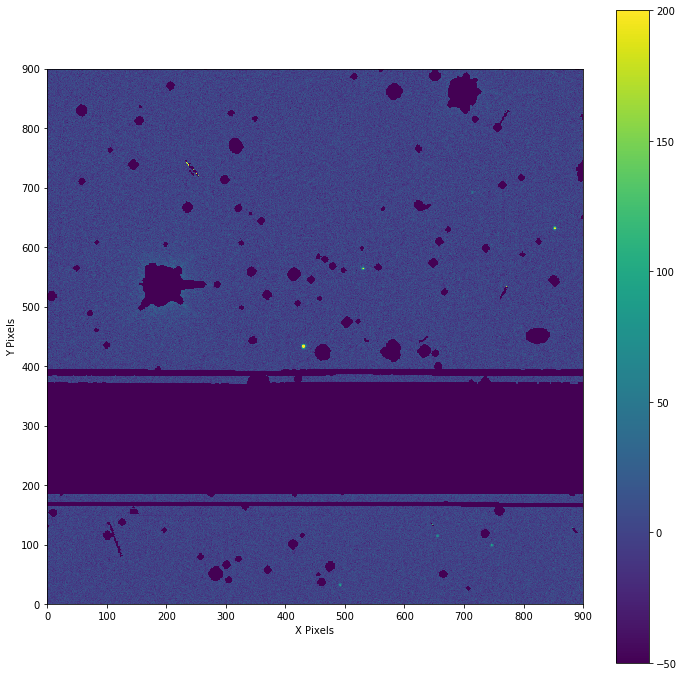

In [21]:
fig = plt.figure(figsize=(12,12))
plt.imshow(images[1] [2700:3600,2900:3800], origin='lower',  vmin=-50, vmax=200)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [22]:
search = kb.stack_search(stack, p)
search.set_debug(True)

In [23]:
search_ang_r = (angle_range[0]/search_margin,
                angle_range[1]*search_margin)
search_vel_r = (velocity_range[0]/search_margin,
                velocity_range[1]*search_margin)
#search.gpu(angle_steps,velocity_steps, *angle_range, *velocity_range, min_observations)

In [24]:
#search.get_results(0,20)

In [25]:
#search.region_search(2400, 1040, 50, 255, 3)
#  xvel, yvel, radius, minLH, minimum observations
res = search.region_search(2000, 1000, 850, 10, 3)

In [26]:
print(len(res))
res

748


[ix: 3125.000000 iy: 3043.000000 fx: 3611.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 244.196732 flux 8571.292969,
 ix: 1384.000000 iy: 2363.000000 fx: 1803.000000 fy: 2430.000000 depth: 0 obs_count: 4 lh: 160.139389 flux 3357.505615,
 ix: 2553.000000 iy: 1987.000000 fx: 3011.000000 fy: 2065.000000 depth: 0 obs_count: 4 lh: 160.102005 flux 3354.926514,
 ix: 2744.000000 iy: 1685.000000 fx: 3296.000000 fy: 1834.000000 depth: 0 obs_count: 4 lh: 159.084610 flux 3322.767578,
 ix: 2395.000000 iy: 416.000000 fx: 2834.000000 fy: 464.000000 depth: 0 obs_count: 4 lh: 158.511627 flux 3380.073975,
 ix: 12.000000 iy: 156.000000 fx: 494.000000 fy: 359.000000 depth: 0 obs_count: 4 lh: 154.102066 flux 3173.546631,
 ix: 122.000000 iy: 3444.000000 fx: 605.000000 fy: 3541.000000 depth: 0 obs_count: 4 lh: 151.486053 flux 3395.624268,
 ix: 45.000000 iy: 1515.000000 fx: 476.000000 fy: 1630.000000 depth: 0 obs_count: 4 lh: 151.298111 flux 3173.739258,
 ix: 3504.000000 iy: 2062.000000 fx: 3997.000000 fy:

In [27]:
matched = []
for r in res:
    if any(abs(r.ix-t.x)<=1 and abs(r.iy-t.y)<=1 for t in results_key ):
        matched.append(r)
len(matched)

174

In [28]:
matched

[ix: 1384.000000 iy: 2363.000000 fx: 1803.000000 fy: 2430.000000 depth: 0 obs_count: 4 lh: 160.139389 flux 3357.505615,
 ix: 2553.000000 iy: 1987.000000 fx: 3011.000000 fy: 2065.000000 depth: 0 obs_count: 4 lh: 160.102005 flux 3354.926514,
 ix: 2744.000000 iy: 1685.000000 fx: 3296.000000 fy: 1834.000000 depth: 0 obs_count: 4 lh: 159.084610 flux 3322.767578,
 ix: 2395.000000 iy: 416.000000 fx: 2834.000000 fy: 464.000000 depth: 0 obs_count: 4 lh: 158.511627 flux 3380.073975,
 ix: 12.000000 iy: 156.000000 fx: 494.000000 fy: 359.000000 depth: 0 obs_count: 4 lh: 154.102066 flux 3173.546631,
 ix: 122.000000 iy: 3444.000000 fx: 605.000000 fy: 3541.000000 depth: 0 obs_count: 4 lh: 151.486053 flux 3395.624268,
 ix: 45.000000 iy: 1515.000000 fx: 476.000000 fy: 1630.000000 depth: 0 obs_count: 4 lh: 151.298111 flux 3173.739258,
 ix: 3504.000000 iy: 2062.000000 fx: 3997.000000 fy: 2271.000000 depth: 0 obs_count: 4 lh: 149.505295 flux 3117.209717,
 ix: 2360.000000 iy: 744.000000 fx: 2802.000000 fy: 

In [77]:
stamps = search.sci_stamps(res[738], 10)

Starting at 0


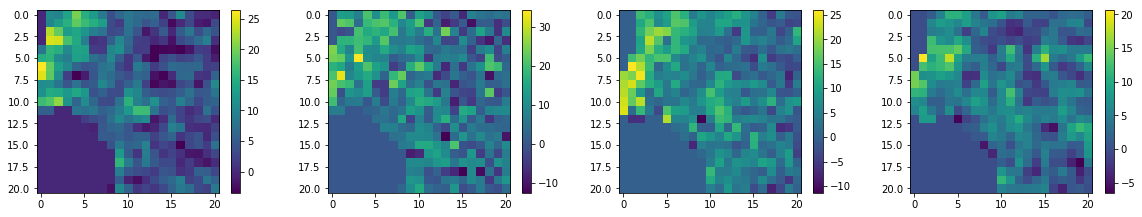

In [78]:
fig = plt.figure(figsize=(20, 100))
set_on = 1
plot_count = len(stamps)
print ('Starting at %i' % int((set_on - 1)*plot_count))
for i in range((set_on-1)*plot_count,set_on*plot_count):
    fig.add_subplot(25,4,i-(set_on-1)*plot_count+1)
    plt.imshow(stamps[i], #cmap=plt.cm.Greys_r, 
               interpolation=None)
    plt.colorbar()

# Examining Pooling

In [29]:
pooled = search.get_psi_pooled()

In [30]:
pooled_imgs = [np.array(im, copy=False) for im in pooled[1]]

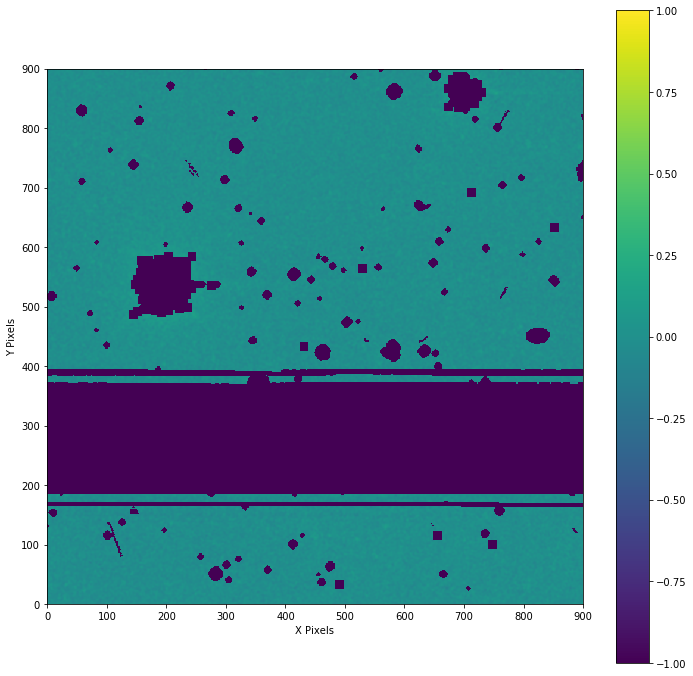

In [31]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[0] [2700:3600,2900:3800], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

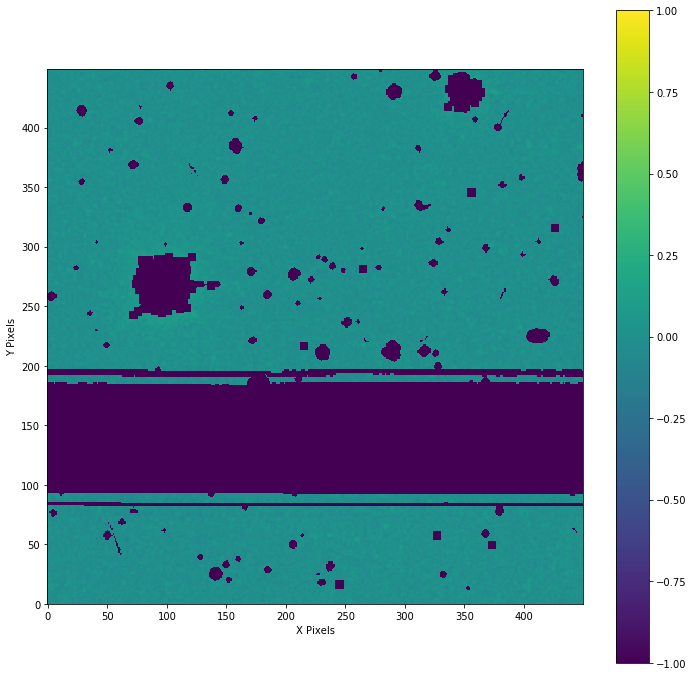

In [32]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[1] [1350:1800,1450:1900], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

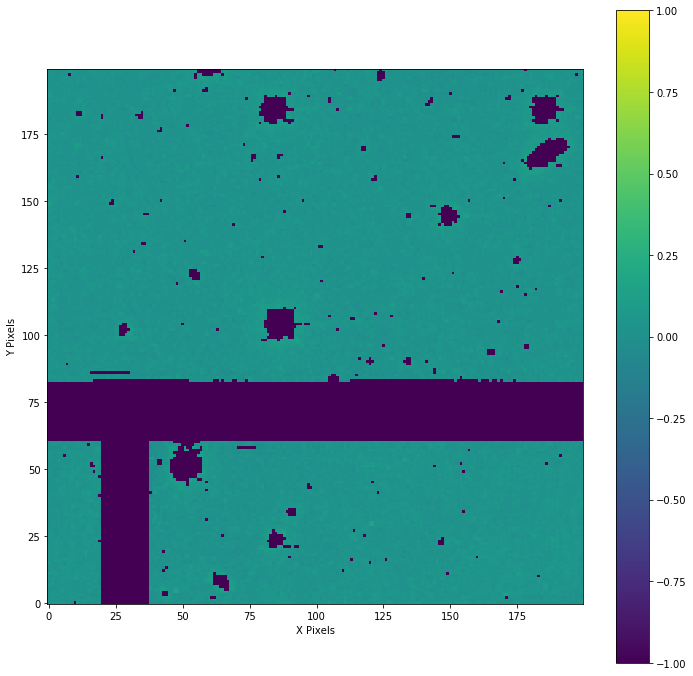

In [33]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[3] [300:500,300:500], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()